# Introduction

$\newcommand{\G}{\mathcal{G}}$
$\newcommand{\V}{\mathcal{V}}$
$\newcommand{\E}{\mathcal{E}}$
$\newcommand{\R}{\mathbb{R}}$

This notebook shows how to apply our graph ConvNet ([paper] & [code]), or any other, to your structured or unstructured data. For this example, we assume that we have $n$ samples $x_i \in \R^{d_x}$ arranged in a data matrix $$X = [x_1, ..., x_n]^T \in \R^{n \times d_x}.$$ Each sample $x_i$ is associated with a vector $y_i \in \R^{d_y}$ for a regression task or a label $y_i \in \{0,\ldots,C\}$ for a classification task.

[paper]: https://arxiv.org/abs/1606.09375
[code]:  https://github.com/mdeff/cnn_graph

From there, we'll structure our data with a graph $\G = (\V, \E, A)$ where $\V$ is the set of $d_x = |\V|$ vertices, $\E$ is the set of edges and $A \in \R^{d_x \times d_x}$ is the adjacency matrix. That matrix represents the weight of each edge, i.e. $A_{i,j}$ is the weight of the edge connecting $v_i \in \V$ to $v_j \in \V$. The weights of that feature graph thus represent pairwise relationships between features $i$ and $j$. We call that regime **signal classification / regression**, as the samples $x_i$ to be classified or regressed are graph signals.

Other modelling possibilities include:
1. Using a data graph, i.e. an adjacency matrix $A \in \R^{n \times n}$ which represents pairwise relationships between samples $x_i \in \R^{d_x}$. The problem is here to predict a graph signal $y \in \R^{n \times d_y}$ given a graph characterized by $A$ and some graph signals $X \in \R^{n \times d_x}$. We call that regime **node classification / regression**, as we classify or regress nodes instead of signals.
2. Another problem of interest is whole graph classification, with or without signals on top. We'll call that third regime **graph classification / regression**. The problem here is to classify or regress a whole graph $A_i \in \R^{n \times n}$ (with or without an associated data matrix $X_i \in \R^{n \times d_x}$) into $y_i \in \R^{d_y}$. In case we have no signal, we can use a constant vector $X_i = 1_n$ of size $n$.

In [1]:
%load_ext autoreload
from lib import models, graph, coarsening, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/zk681xh/private/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zk681xh/private/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zk681xh/private/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zk681xh/private/env/lib/python3.7/site-packages/tensorflow/pyth

hello world


In [2]:
  %reload_ext autoreload


# 1 Data

For the purpose of the demo, let's create a random data matrix $X \in \R^{n \times d_x}$ and somehow infer a label $y_i = f(x_i)$.

Then split this dataset into training, validation and testing sets.

# 2 Graph

The second thing we need is a **graph between features**, i.e. an adjacency matrix $A \in \mathbb{R}^{d_x \times d_x}$.
Structuring data with graphs is very flexible: it can accomodate both structured and unstructured data.
1. **Structured data**.
    1. The data is structured by an Euclidean domain, e.g. $x_i$ represents an image, a sound or a video. We can use a classical ConvNet with 1D, 2D or 3D convolutions or a graph ConvNet with a line or grid graph (however losing the orientation).
    2. The data is structured by a graph, e.g. the data lies on a transportation, energy, brain or social network.
2. **Unstructured data**. We could use a fully connected network, but the learning and computational complexities are gonna be large. An alternative is to construct a sparse similarity graph between features (or between samples) and use a graph ConvNet, effectively structuring the data and drastically reducing the number of parameters through weight sharing. As for classical ConvNets, the number of parameters are independent of the input size.

There are many ways, supervised or unsupervised, to construct a graph given some data. And better the graph, better the performance ! For this example we'll define the adjacency matrix as a simple similarity measure between features. Below are the choices one has to make when constructing such a graph.
1. The distance function. We'll use the Euclidean distance $d_{ij} = \|x_i - x_j\|_2$.
2. The kernel. We'll use the Gaussian kernel $a_{ij} = \exp(d_{ij}^2 / \sigma^2)$.
3. The type of graph. We'll use a $k$ nearest neigbors (kNN) graph.

In [3]:
import keras
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


Using TensorFlow backend.


In [4]:
test_images.reshape((10000, 28*28)).T.shape

(784, 10000)

In [5]:
z = graph.grid(28)
dist, idx = graph.distance_sklearn_metrics(z, k=8, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)
print('d = |V| = {}, k|V| < |E| = {}'.format(0, A.nnz))


d = |V| = 0, k|V| < |E| = 6396


In [6]:
idx[28]

array([ 0, 56, 29,  1, 57, 84, 30, 58])

In [7]:
def get_laplacian_of_size(grid_size):
    z = graph.grid(grid_size)
    dist, idx = graph.distance_sklearn_metrics(z, k=8, metric='euclidean')
    A = graph.adjacency(dist, idx).astype(np.float32)
    return graph.laplacian(A, normalized=True)

In [8]:
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

X_train = train_images.reshape((60000, 28*28)) 
X_test = test_images.reshape((10000, 28*28)) 
#X_train = coarsening.perm_data(train_images.reshape((60000, 28*28)), perm)
#X_val = coarsening.perm_data(X_val, perm)
#X_test = coarsening.perm_data(test_images.reshape((10000, 28*28)), perm)

Layer 0: M_0 = |V| = 928 nodes (144 added),|E| = 3198 edges
Layer 1: M_1 = |V| = 464 nodes (57 added),|E| = 1439 edges
Layer 2: M_2 = |V| = 232 nodes (13 added),|E| = 700 edges
Layer 3: M_3 = |V| = 116 nodes (0 added),|E| = 328 edges


In [9]:
X_train.shape

(60000, 784)

In [35]:
#L = [graph.laplacian(A, normalized=True) for A in graphs]
L = [get_laplacian_of_size(s) for s in [28,14,7]]
#graph.plot_spectrum(L)

In [36]:
(L[0].todense()-L[0].todense().T).max()

1.4901161e-08

# 3 Graph ConvNet

Here we apply the graph convolutional neural network to signals lying on graphs. After designing the architecture and setting the hyper-parameters, the model takes as inputs the data matrix $X$, the target $y$ and a list of graph Laplacians $L$, one per coarsening level.

The data, architecture and hyper-parameters are absolutely *not engineered to showcase performance*. Its sole purpose is to illustrate usage and functionality.

In [37]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 40
params['batch_size']     = 100
params['eval_frequency'] = 200

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = train_labels.max() + 1
#assert C == np.unique(y).size
n_train = 60000
# Architecture.
params['F']              = [32,64,64,128]  # Number of graph convolutional filters.
params['K']              = [3,3,3,3]  # Polynomial orders.
params['p']              = [2, 2, 1]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [38]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, train_labels, X_test, test_labels)


NN architecture
  input: M_0 = 784
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 784 * 32 / 2 = 12544
    weights: F_0 * F_1 * K_1 = 1 * 32 * 3 = 96
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 196 * 64 / 1 = 12544
    weights: F_1 * F_2 * K_2 = 32 * 64 * 3 = 6144
    biases: F_2 = 64
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 196 * 64 / 2 = 6272
    weights: F_2 * F_3 * K_3 = 64 * 64 * 3 = 12288
    biases: F_3 = 64
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 49 * 128 / 1 = 6272
    weights: F_3 * F_4 * K_4 = 64 * 128 * 3 = 24576
    biases: F_4 = 128
  layer 5: fc1
    representation: M_5 = 512
    weights: M_4 * M_5 = 6272 * 512 = 3211264
    biases: M_5 = 512
  layer 6: logits (softmax)
    representation: M_6 = 10
    weights: M_5 * M_6 = 512 * 10 = 5120
    biases: M_6 = 10
hello world
step 200 / 24000 (epoch 0.33 / 40):
  learning_rate = 1.00e-03, loss_average = 1.98e+00
  validation accuracy: 31.36 (3136 / 1

  validation accuracy: 80.71 (8071 / 10000), f1 (weighted): 80.80, loss: 7.08e-01
  time: 5061s (wall 1145s)
step 7800 / 24000 (epoch 13.00 / 40):
  learning_rate = 5.40e-04, loss_average = 6.83e-01
  validation accuracy: 79.83 (7983 / 10000), f1 (weighted): 79.62, loss: 7.23e-01
  time: 5194s (wall 1175s)
step 8000 / 24000 (epoch 13.33 / 40):
  learning_rate = 5.13e-04, loss_average = 6.87e-01
  validation accuracy: 79.89 (7989 / 10000), f1 (weighted): 79.45, loss: 7.24e-01
  time: 5326s (wall 1206s)
step 8200 / 24000 (epoch 13.67 / 40):
  learning_rate = 5.13e-04, loss_average = 7.10e-01
  validation accuracy: 80.06 (8006 / 10000), f1 (weighted): 80.15, loss: 7.11e-01
  time: 5460s (wall 1236s)
step 8400 / 24000 (epoch 14.00 / 40):
  learning_rate = 5.13e-04, loss_average = 6.92e-01
  validation accuracy: 80.36 (8036 / 10000), f1 (weighted): 80.66, loss: 6.95e-01
  time: 5592s (wall 1267s)
step 8600 / 24000 (epoch 14.33 / 40):
  learning_rate = 4.88e-04, loss_average = 6.98e-01
  val

step 16000 / 24000 (epoch 26.67 / 40):
  learning_rate = 2.64e-04, loss_average = 5.96e-01
  validation accuracy: 82.01 (8201 / 10000), f1 (weighted): 82.23, loss: 6.42e-01
  time: 10641s (wall 2436s)
step 16200 / 24000 (epoch 27.00 / 40):
  learning_rate = 2.64e-04, loss_average = 6.20e-01
  validation accuracy: 82.09 (8209 / 10000), f1 (weighted): 82.30, loss: 6.37e-01
  time: 10773s (wall 2467s)
step 16400 / 24000 (epoch 27.33 / 40):
  learning_rate = 2.50e-04, loss_average = 6.10e-01
  validation accuracy: 81.97 (8197 / 10000), f1 (weighted): 81.81, loss: 6.53e-01
  time: 10907s (wall 2498s)
step 16600 / 24000 (epoch 27.67 / 40):
  learning_rate = 2.50e-04, loss_average = 6.20e-01
  validation accuracy: 81.68 (8168 / 10000), f1 (weighted): 81.38, loss: 6.65e-01
  time: 11040s (wall 2529s)
step 16800 / 24000 (epoch 28.00 / 40):
  learning_rate = 2.50e-04, loss_average = 6.08e-01
  validation accuracy: 82.67 (8267 / 10000), f1 (weighted): 82.59, loss: 6.31e-01
  time: 11173s (wall 25

In [39]:
res = model.evaluate(rotated_test, test_labels)
print(res[0])

INFO:tensorflow:Restoring parameters from /Users/zk681xh/private/cnn_graph2/lib/../checkpoints/demo/model-24000
accuracy: 82.90 (8290 / 10000), f1 (weighted): 82.58, loss: 6.30e-01
time: 25s (wall 7s)


In [40]:
res = model.evaluate(X_test, test_labels)
print(res[0])

INFO:tensorflow:Restoring parameters from /Users/zk681xh/private/cnn_graph2/lib/../checkpoints/demo/model-24000
accuracy: 83.33 (8333 / 10000), f1 (weighted): 83.04, loss: 6.14e-01
time: 24s (wall 6s)


In [99]:
out = model.graph.get_tensor_by_name("conv2/pooling/Reshape_1:0")

In [19]:
rotated_test = np.reshape(np.rot90(np.reshape(X_test, (10000,28,28)),1, (1,2)), (10000,28*28))



In [101]:
sess = model._get_session(None)

INFO:tensorflow:Restoring parameters from /Users/zk681xh/private/cnn_graph2/lib/../checkpoints/demo/model-600


In [102]:
rotated_input = np.reshape(np.rot90(np.reshape(X_train[:100,:], (100,28,28)),1, (1,2)), (100,28*28))
normal_input = X_train[:100,:]

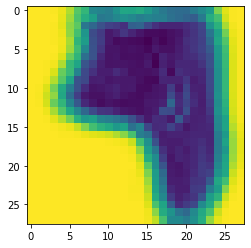

In [77]:
from matplotlib import pyplot as plt
plt.imshow(np.rot90(normal_image_tensor,1,(0,1)))

In [121]:
feed_dict = {model.ph_data: normal_input, model.ph_dropout: 1}
normal_tensor = sess.run(out, feed_dict)
feed_dict = {model.ph_data: rotated_input, model.ph_dropout: 1}
rotated_tensor = sess.run(out, feed_dict)

In [125]:
rotated_tensor[0,:,2].shape

(49,)

In [126]:
normal_image_tensor = np.reshape(normal_tensor[0,:,2],(7,7))
rotated_image_tensor = np.reshape(rotated_tensor[0,:,2],(7,7))

In [127]:
rotated_tensor = np.reshape(res, (100,28,28,32))

In [129]:
(np.rot90(normal_image_tensor,1,(0,1)) - rotated_image_tensor)

0.0030962527

In [110]:
rotated_image_tensor

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# 4 Evaluation

We often want to monitor:
1. The convergence, i.e. the training loss and the classification accuracy on the validation set.
2. The performance, i.e. the classification accuracy on the testing set (to be compared with the training set accuracy to spot overfitting).

The `model_perf` class in [utils.py](utils.py) can be used to compactly evaluate multiple models.

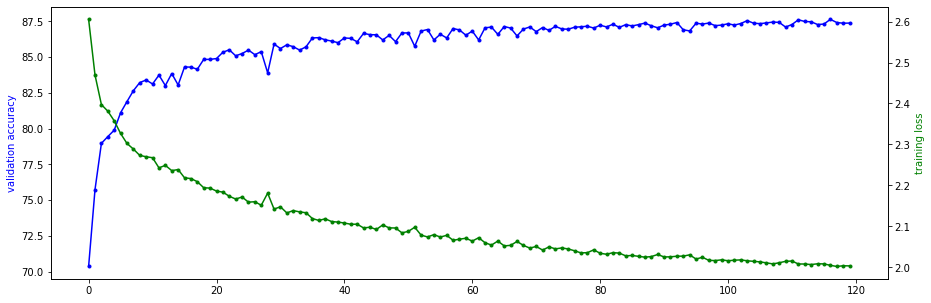

In [110]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(accuracy, 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(loss, 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

In [111]:
print('Time per step: {:.2f} ms'.format(t_step*1000))

Time per step: 48.86 ms


In [112]:
res = model.evaluate(X_test, test_labels)
print(res[0])

INFO:tensorflow:Restoring parameters from /Users/zk681xh/private/cnn_graph/lib/../checkpoints/demo/model-24000
accuracy: 87.38 (8738 / 10000), f1 (weighted): 87.28, loss: 2.00e+00
time: 11s (wall 2s)


In [113]:
laplacian = graph.laplacian(A, normalized=True)

In [114]:
import numpy as np
lapl2 = 2 * np.matmul(A.todense(), A.todense()) - np.identity(784)

In [116]:
j = 2
a = result[:,j]
kernel = a[0] * np.identity(784) + a[1] * laplacian# + a[2] * lapl2

In [117]:
result.shape

(2, 16)

In [118]:
output_array = np.zeros((28,28))
for i in range(28):
    for j in range(28):
        val = kernel[203,i*28+j]
        if not val==0:
            output_array[i,j] = val

In [119]:
output_array[5:10, 5:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.03341748, -0.05207108, -0.03341748,  0.        ],
       [ 0.        , -0.05207108,  0.14745525, -0.05207106,  0.        ],
       [ 0.        , -0.03341748, -0.05207106, -0.03341747,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

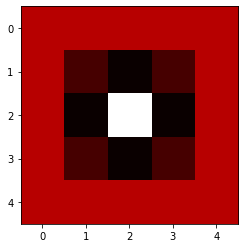

In [120]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(output_array[5:10, 5:10], cmap='hot', interpolation='nearest')
plt.show()

In [121]:
output_array[5:10, 5:10]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.03341748, -0.05207108, -0.03341748,  0.        ],
       [ 0.        , -0.05207108,  0.14745525, -0.05207106,  0.        ],
       [ 0.        , -0.03341748, -0.05207106, -0.03341747,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [134]:
def generate_kernel(p):
    a = result[:,p]
    kernel = a[0] * np.identity(784) + a[1] * laplacian# + a[2] * lapl2
    output_array = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            val = kernel[203,i*28+j]
            if not val==0:
                output_array[i,j] = val
    return output_array[6:9, 6:9]

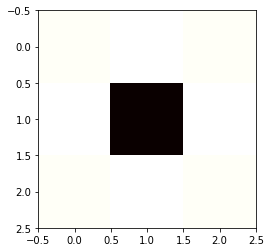

In [136]:
plt.imshow(generate_kernel(8), cmap='hot', interpolation='nearest')
plt.show()

In [137]:
generate_kernel(8)

array([[ 0.01174721,  0.01830449,  0.01174721],
       [ 0.01830449, -0.63152501,  0.01830449],
       [ 0.01174721,  0.01830449,  0.01174721]])

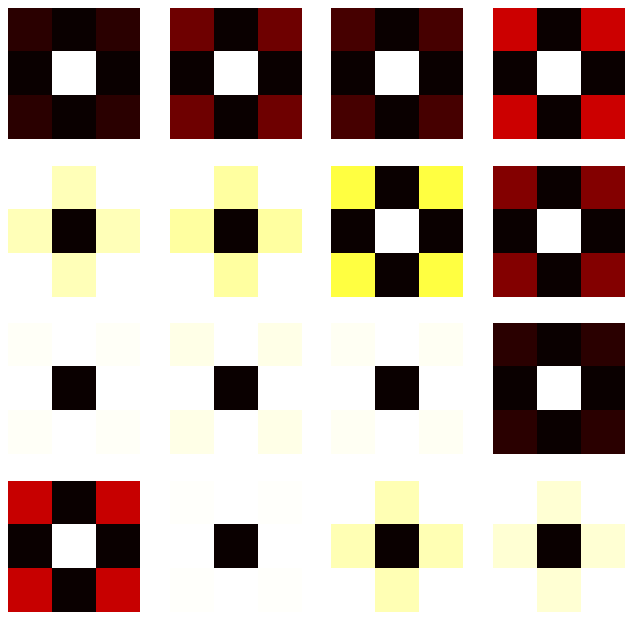

In [130]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.axis('off')

for i in range(1, 17):
    plt.subplot(4,4, i)
    plt.axis('off')
    plt.imshow(generate_kernel(i-1), cmap='hot', interpolation='nearest')

plt.show()


In [61]:
x = np.array([generate_kernel(i) for i in range(64)])

In [62]:
np.save('kernels5x5.npy', x)

In [131]:
laplacian

<784x784 sparse matrix of type '<class 'numpy.float32'>'
	with 7180 stored elements in Compressed Sparse Row format>